In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn

import shap


from captum.attr import IntegratedGradients, Deconvolution, GuidedBackprop, DeepLift

In [42]:
train = np.genfromtxt("mnist_train.csv", delimiter = ",", skip_header = 1, dtype=int)/255

# train_y = onehot(train[:,0]*255)
train_y = (train[:,0]*255).astype(int)

train = train[train_y == 0 | (train_y == 1).astype(int)]
train_y = train_y[train_y == 0 | (train_y == 1).astype(int)]

In [115]:
test = np.genfromtxt("mnist_test.csv", delimiter = ",", skip_header = 1, dtype=int)/255
test_y = (test[:,0]*255).astype(int)

test_dat = torch.Tensor(test[test_y == 0 | (test_y == 1).astype(int)])

In [43]:
train_y = torch.tensor(train_y, dtype= torch.long)

In [44]:
train_dat = torch.Tensor(train)

In [45]:
batch_size = 32

In [59]:
def onehot(l):
    one = torch.zeros((l.shape[0],10))

    for i, o in enumerate(l):
        one[i,int(o)] = 1

    return one


def loader(data, data_y, batch_size):
    for i in range(len(data)//batch_size):
        x, y = data[i*batch_size:(i+1)*batch_size,1:], data_y[i*batch_size:(i+1)*batch_size]
        yield x, y


train_loader = loader(train_dat, train_y, batch_size)


In [80]:
class nemt(nn.Module):
    def __init__(self):
        super(nemt, self).__init__()
        self.get_res = False
        self.conv = nn.Conv2d(1, 2, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(288, 64)
        # self.fc1 = lambda x: x
        self.fc2 = lambda x: x
        # self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv(x.view(-1,28,28).unsqueeze(1))
        if self.get_res:
            return x
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.fc1(x.reshape(-1,288)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = nemt()


In [81]:
loss_fn = nn.CrossEntropyLoss()

def train(model, n_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

    for i in range(n_epochs):
        train_loader = loader(train_dat, train_y, batch_size)

        running_loss = 0.0
        running_acc = 0.0
        c = 0
        for X, y in tqdm(train_loader, total = len(train_y)//batch_size):
            pred = model(X)
            loss = loss_fn(pred, y)

            acc = (pred.argmax(1) == y).detach().float().mean()

            running_loss += loss.detach().numpy()
            running_acc += acc

            loss.backward()
            optimizer.step()
            c += 1
        print(running_loss/c, running_acc/c)

train(model, 100)

  0%|          | 0/395 [00:00<?, ?it/s]

0.5620113291317903 tensor(0.9867)


  0%|          | 0/395 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
i = 4

X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
pred_label = model(X)

print(y, pred_label.argmax())

tensor([1]) tensor(1)


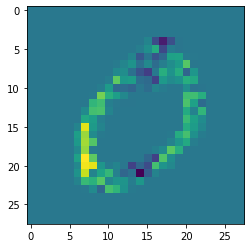

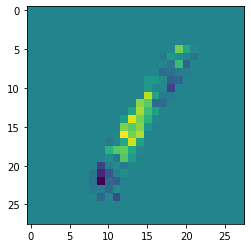

In [10]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
import torchvision

# model = torchvision.models.resnet18(pretrained=True)
# model = model.eval()


for i in range(2):
    # i = 1

    X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
    pred_label = model(X)

    # print(pred_label.shape, X.shape)
    # print(torch.argmax(pred_label), y)
    integrated_gradients = IntegratedGradients(model)

    attributions_ig = integrated_gradients.attribute(X, target=torch.argmax(pred_label))

    v = attributions_ig.squeeze(0).view(28,28).cpu().detach().numpy()
    plt.imshow(v)
    plt.show()
# plt.imshow(v + X.view(28,28).cpu().detach().numpy())
# viz.visualize_image_attr(v,
#                             torch.argmax(y),
#                             method='heat_map',)
#                             # show_colorbar=True,)
# #                             # sign='positive',)
# #                             # outlier_perc=1)

In [11]:
# params = next(model.parameters()).detach().view(-1,28,28)

# for p in params:
#     plt.imshow(p)
#     plt.show()
N = 200
test_images = train_dat[N:N+2,1:]
bgr = train_dat[:N,1:]

e = shap.DeepExplainer(model, bgr)
shap_values = e.shap_values(test_images)


In [12]:
train_loader = loader(train_dat, train_y, batch_size)

for X, y in train_loader:

    print(model(X).argmax(1),"\n", y)

    print((model(X).argmax(1) == y).detach().float().mean())
    break

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1]) 
 tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1])
tensor(1.)


In [25]:
# plt.imshow(shap_numpy[0][1])

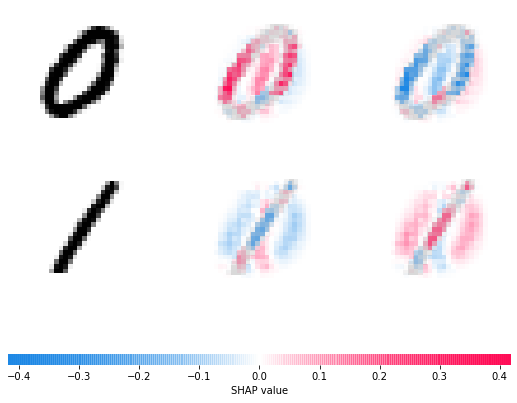

In [17]:
shap_numpy = [np.array(s.reshape(-1,28,28)) for s in shap_values]
test_numpy = test_images.numpy().reshape(-1,28,28)

shap.image_plot(shap_numpy, -test_numpy)

Parameter containing:
tensor([[[[ 0.1198, -0.0838,  0.0616,  0.2724,  0.0504],
          [-0.0273, -0.2746, -0.0269,  0.2755,  0.3335],
          [-0.2639, -0.4173, -0.0984,  0.3393,  0.4197],
          [-0.2144, -0.0610,  0.0515,  0.0891,  0.0623],
          [-0.2933, -0.2750,  0.1726,  0.3334,  0.1783]]],


        [[[-0.0488,  0.2677,  0.2465,  0.2337,  0.1311],
          [-0.3170,  0.1289,  0.0484,  0.2190,  0.2637],
          [ 0.1799,  0.2394,  0.3857,  0.3873,  0.1481],
          [ 0.1140,  0.0905,  0.4024,  0.0605,  0.2981],
          [ 0.3046,  0.2361,  0.2743,  0.3249,  0.3470]]]], requires_grad=True)


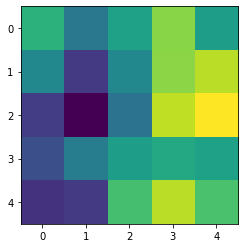

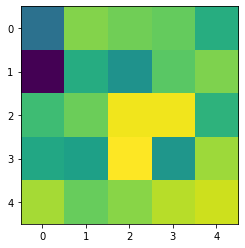

In [14]:
p = model.parameters()
c = next(p)
print(c)
for i in range(2):
    plt.imshow(c[i][0].detach().numpy())
    plt.show()


In [55]:
methods

[captum.attr._core.integrated_gradients.IntegratedGradients,
 captum.attr._core.guided_backprop_deconvnet.Deconvolution,
 captum.attr._core.guided_backprop_deconvnet.GuidedBackprop,
 captum.attr._core.deep_lift.DeepLift]

In [109]:
from captum.attr import IntegratedGradients, Deconvolution, GuidedBackprop, DeepLift, LRP

methods = [IntegratedGradients, GuidedBackprop, DeepLift, LRP]




Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


In [117]:
from scipy.stats import spearmanr

def get_corrs(a):
    A = np.empty((4,4))
    for x in range(4):
        for y in range(4):
            A[x,y] = spearmanr(a[x],a[y])[0] 
    return A

def get_attrs(dat):
    all_attr = []
    for d in dat:
        img = d[1:]
        target = model(img).argmax(1)
        attributions = []

        for m in methods:
            x = m(model)
            attr = x.attribute(img.unsqueeze(0), target=target)
            attributions.append(attr.detach().squeeze(0))
        all_attr.append(attributions)

    return all_attr


all_attr = get_attrs(test_dat)

In [118]:
corrs = [get_corrs(a) for a in all_attr]

In [125]:
np.array(corrs).mean(axis =0)

array([[1.        , 0.44934619, 0.71051886, 0.92353976],
       [0.44934619, 1.        , 0.38097072, 0.46356532],
       [0.71051886, 0.38097072, 1.        , 0.72810777],
       [0.92353976, 0.46356532, 0.72810777, 1.        ]])

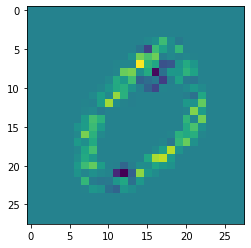

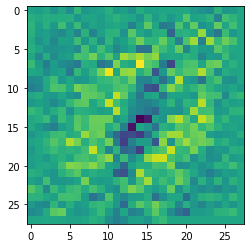

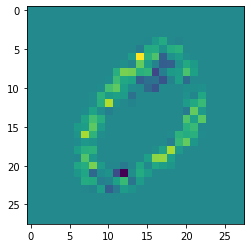

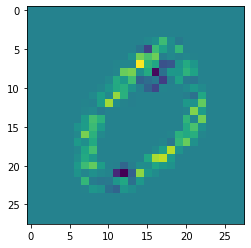

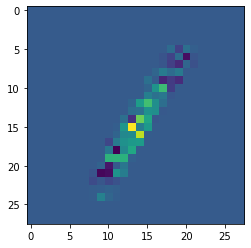

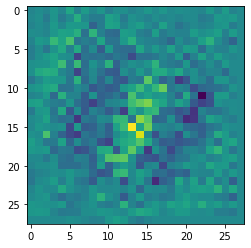

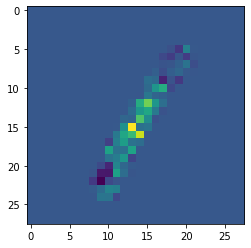

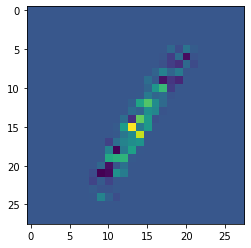

In [96]:
for a in attributions:
    plt.imshow(a.reshape(28,28))
    plt.show()

# plt.imshow((attributions[0]-attributions[4]).reshape(28,28))

In [15]:
model.get_res = True

0.21716492


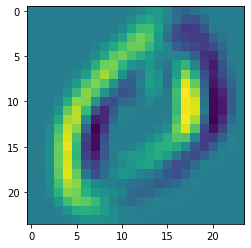

0.8981702


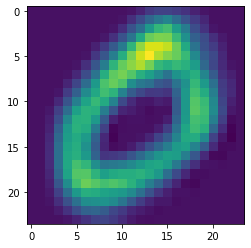

0.14643984


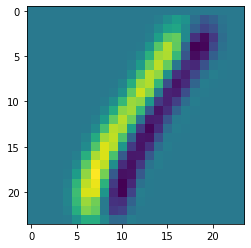

0.42230278


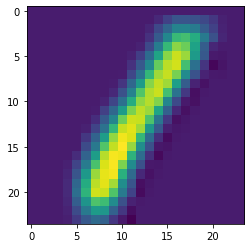

In [16]:
t = train_dat[:32,1:] 
# t = torch.Tensor(np.random.random((32,28*28)))
for k in range(2):
    res = model(t)[k]

    for i in range(2):
        plt.imshow(res[i].detach().numpy())
        print(np.mean(res[i].detach().numpy()))
        plt.show()